# Impots

In [1]:
%%capture
# !pip install pandas seaborn numpy matplotlib scikit-learn tifffile scikit-image tqdm rasterio cloudSEN12 imagecodecs

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tifffile as tiff
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import skimage
from skimage.io import imread, imsave
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
import keras
import keras.layers

sys.path.insert(0, '../')
from src.utils import *
from src.config import *
from src.prepare_data import prepare_SPARCS, prepare_biome8, prepare_S2

seed_value = 42

# Set the random seed for Python's built-in random module
random.seed(seed_value)

# Set the random seed for numpy
np.random.seed(seed_value)

# Set the random seed for TensorFlow
tf.random.set_seed(seed_value)

2023-08-07 07:55:17.706903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 07:55:18.768772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Visualizations

In [3]:
# full data label distribution

# - clear (0%)

# - low-cloudy (1% - 25%) 

# - almost clear (25% - 45%)

# - mid-cloudy (45% - 65%)

# - cloudy (65% >)

In [4]:
ROI_collection = "24__ROI_0549__ROI_0570"
ROI = "ROI_0549"

In [5]:
# ROI
print('The folder contains ' + str(len(os.listdir(Path(cloudSEN12_path, ROI_collection)))) + ' regions of interest (ROIs) of the 9880 available.')

The folder contains 20 regions of interest (ROIs) of the 9880 available.


Each ROI has 5 5090x5090 meters image patches (IPs) collected on different dates.
Each IP has 509x509 pixels and 17 bands.


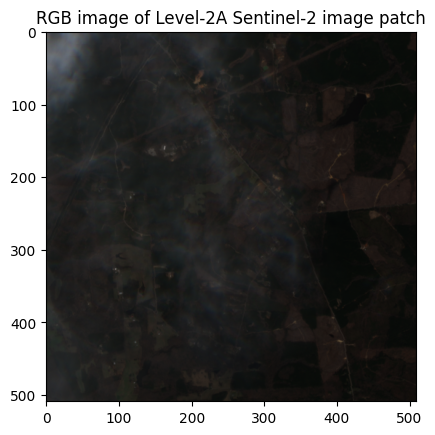

In [6]:
# Images
print(f'Each ROI has {str(len(os.listdir(Path(cloudSEN12_path, ROI_collection, ROI))))} 5090x5090 meters image patches (IPs) collected on different dates.')
im = tiff.imread(Path(cloudSEN12_path, ROI_collection, ROI, '20200306T155019_20200306T160015_T17SQB/S2L2A.tif'))
print(f'Each IP has {str(im.shape[0])}x{str(im.shape[1])} pixels and {str(im.shape[2])} bands.')
im = im[:, :, 1:4]
im = np.flip(im, axis=2)
im = np.clip(im/10000, 0,1)
plt.title('RGB image of Level-2A Sentinel-2 image patch')
plt.imshow(im)

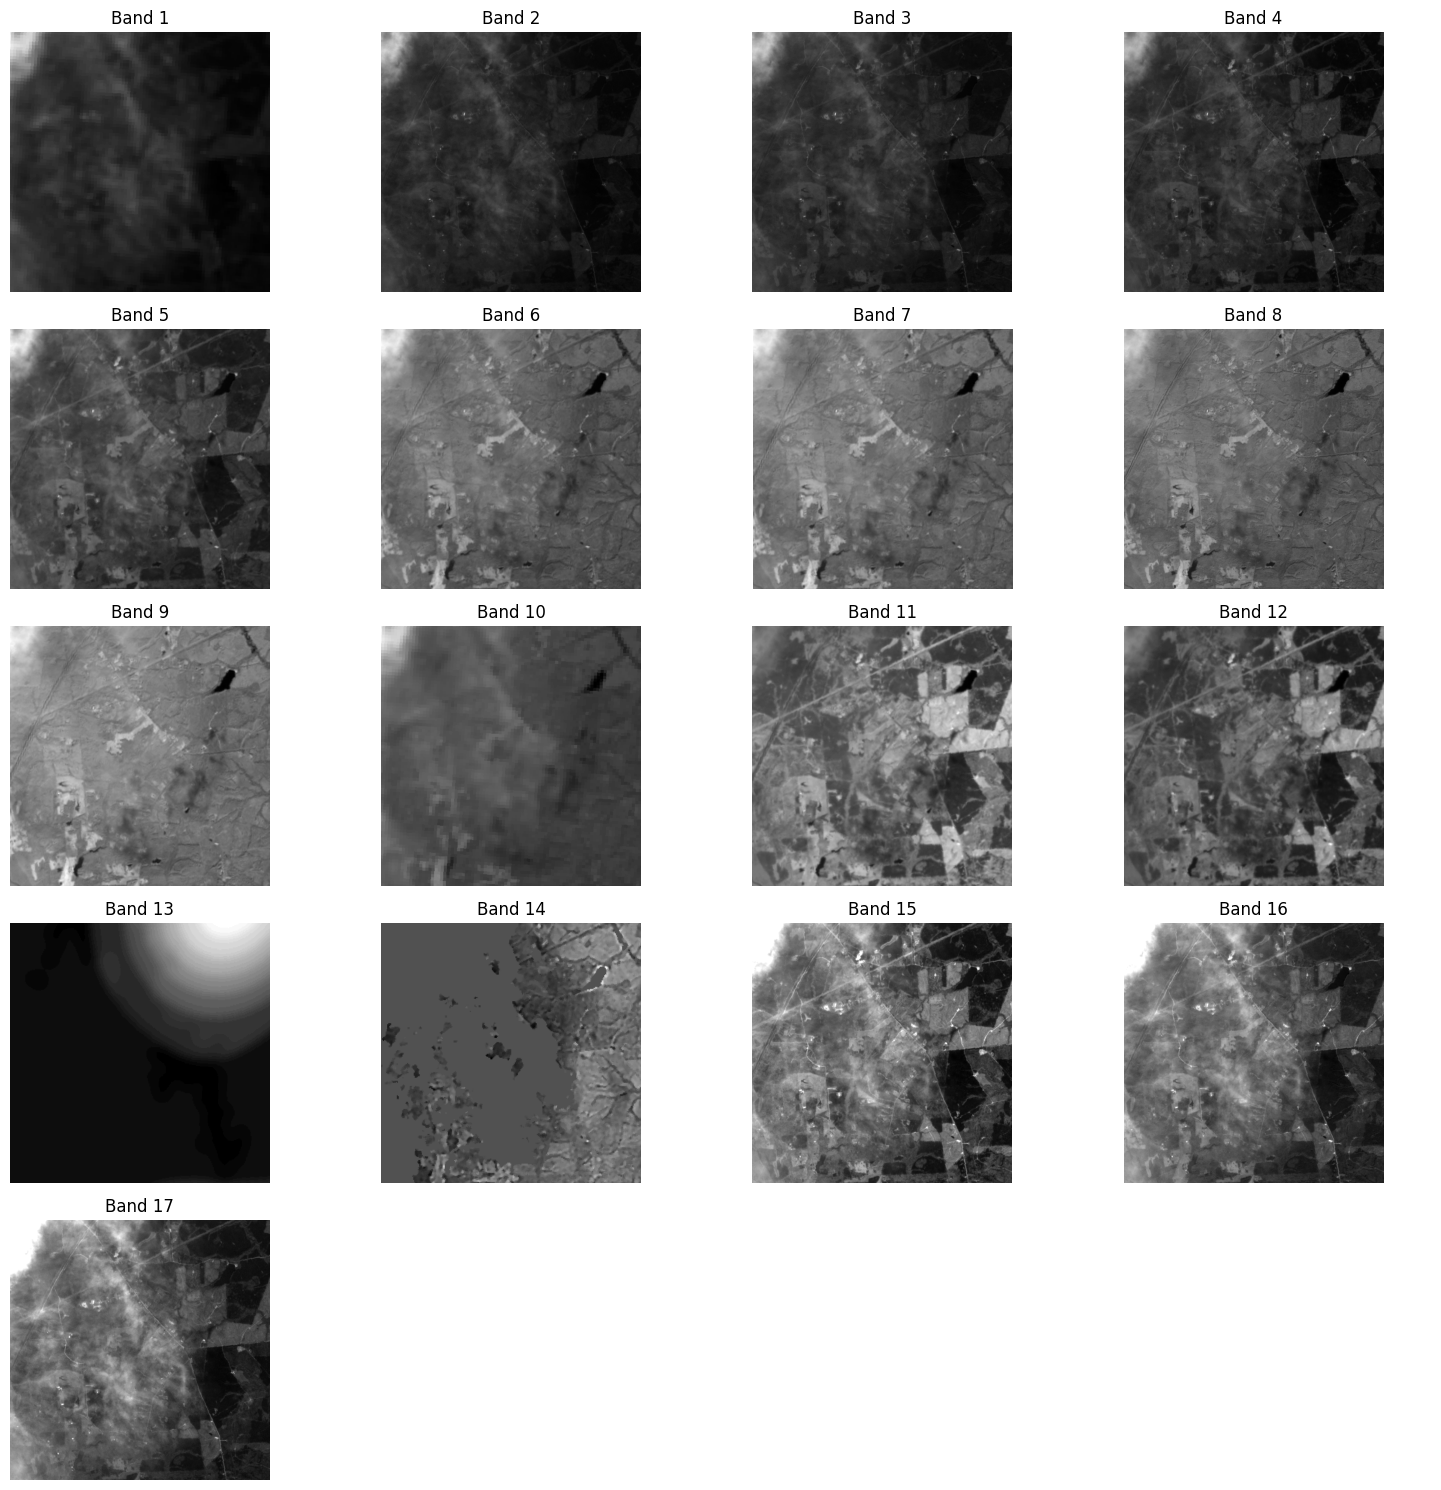

In [7]:
data = tiff.imread(Path(cloudSEN12_path, ROI_collection, ROI, '20200306T155019_20200306T160015_T17SQB/S2L2A.tif'))

# The bands can be seen here: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data

# normalize the data
data = np.clip(data/10000, 0,1)

# Determine the shape of the data
num_bands = data.shape[2]

# Calculate the number of rows and columns for the subplots
num_rows = int(np.ceil(np.sqrt(num_bands)))
num_cols = int(np.ceil(num_bands / num_rows))

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Iterate over the bands and plot each slice
for i in range(num_bands):
    axs[i].imshow(data[:, :, i], cmap='gray')
    axs[i].set_title("Band {}".format(i + 1))
    axs[i].axis('off')

# Hide any remaining empty subplots
for j in range(num_bands, len(axs)):
    axs[j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

In [8]:
# List of available masks for each IP
os.listdir(Path(cloudSEN12_path, ROI_collection, ROI, "20200306T155019_20200306T160015_T17SQB", "labels"))

['manual_hq.tif',
 'kappamask_L1C.tif',
 'CD-FCNN-RGBI.tif',
 'manual_sc.tif',
 'qa60.tif',
 'CD-FCNN-RGBISWIR.tif',
 'fmask.tif',
 's2cloudless.tif',
 'sen2cor.tif',
 'kappamask_L2A.tif']

Each ROI has 10 ground truth masks created using a series of different methods.
Shape: (509, 509)
Maximum = 3.0 ; Minimum = 0.0
Unique values: [0. 1. 2. 3.]


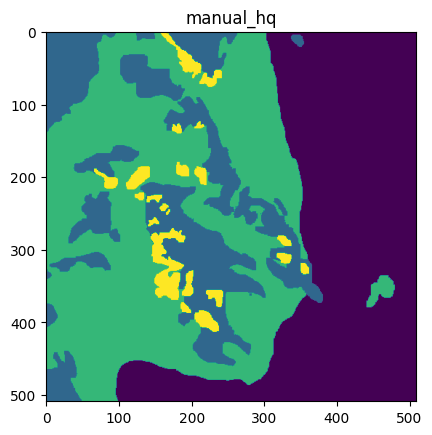

Shape: (509, 509)
Maximum = 5.0 ; Minimum = 1.0
Unique values: [1. 2. 3. 4. 5.]


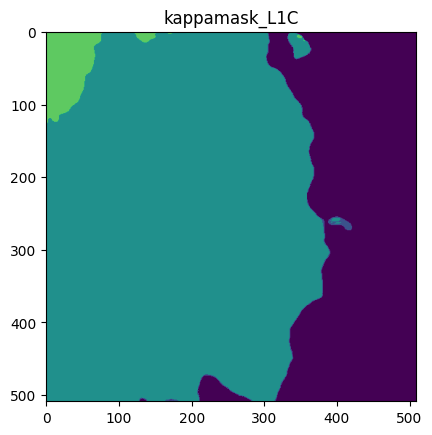

Shape: (509, 509)
Maximum = 9997 ; Minimum = 2
Unique values: [   2    3    4 ... 9995 9996 9997]


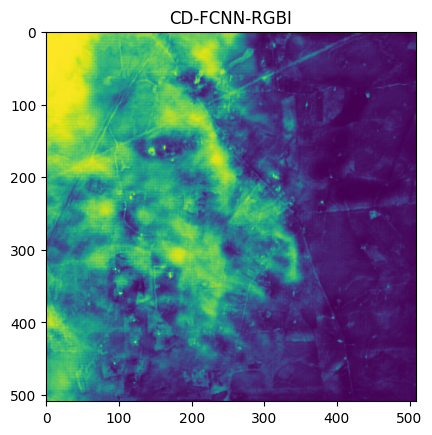

Shape: (509, 509)
Maximum = 3.0 ; Minimum = -3.4e+38
Unique values: [-3.4e+38  0.0e+00  1.0e+00  2.0e+00  3.0e+00]


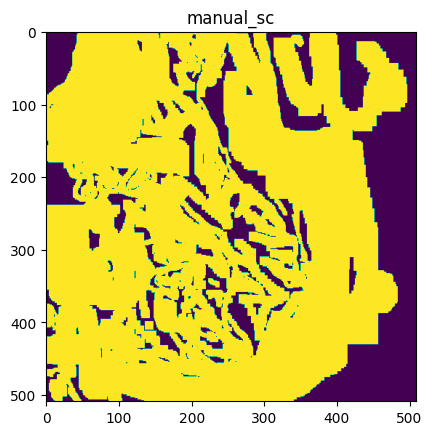

Shape: (509, 509)
Maximum = 2048.0 ; Minimum = 0.0
Unique values: [   0. 1024. 2048.]


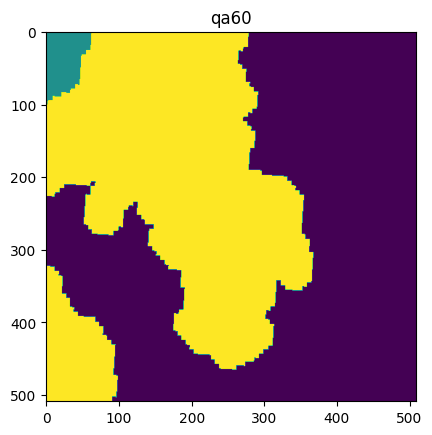

Shape: (509, 509)
Maximum = 9995 ; Minimum = 0
Unique values: [   0    1    2 ... 9993 9994 9995]


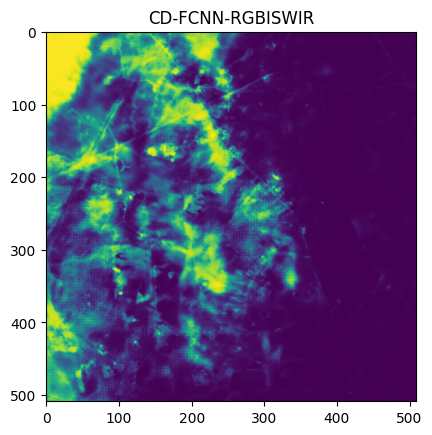

Shape: (509, 509)
Maximum = 4.0 ; Minimum = 0.0
Unique values: [0. 1. 2. 3. 4.]


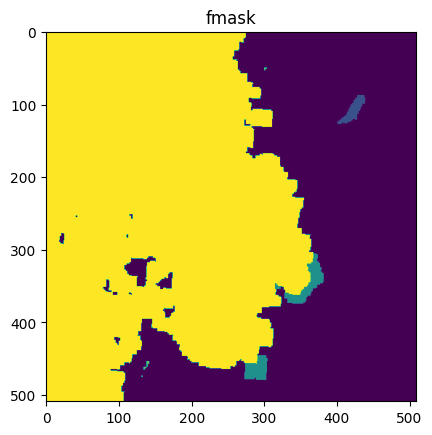

Shape: (509, 509)
Maximum = 100.0 ; Minimum = 1.0
Unique values: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100.]


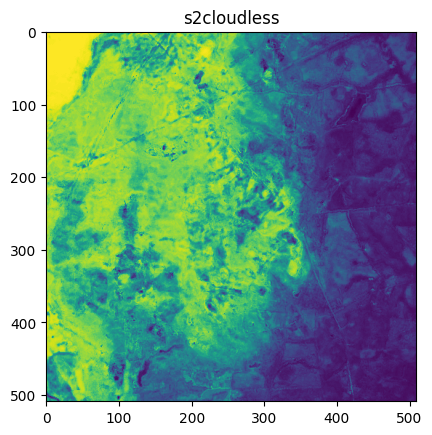

Shape: (509, 509)
Maximum = 10.0 ; Minimum = 2.0
Unique values: [ 2.  4.  5.  6.  7.  8.  9. 10.]


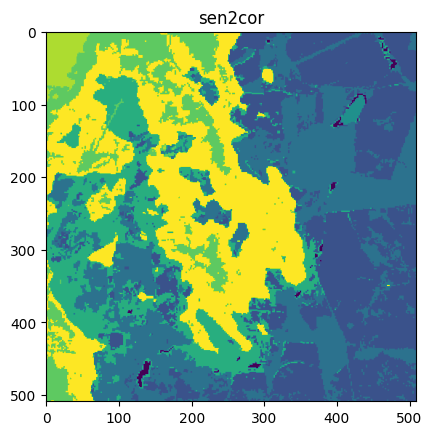

Shape: (509, 509)
Maximum = 4.0 ; Minimum = 1.0
Unique values: [1. 2. 3. 4.]


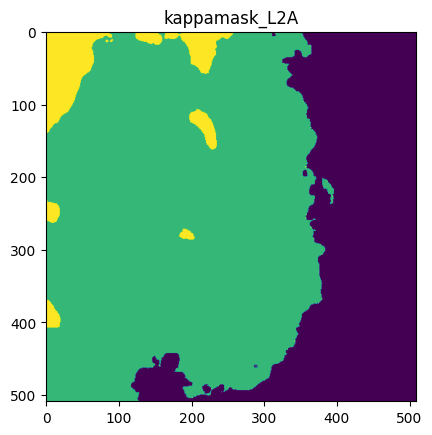

In [9]:
# Image ground truth 
print(f'Each ROI has {str(len(os.listdir(Path(cloudSEN12_path, ROI_collection, ROI, "20200306T155019_20200306T160015_T17SQB", "labels"))))} ground truth masks created using a series of different methods.')

for m in os.listdir(Path(cloudSEN12_path, ROI_collection, ROI, "20200306T155019_20200306T160015_T17SQB", "labels")):
    mask = Image.open(Path(cloudSEN12_path, ROI_collection, ROI, "20200306T155019_20200306T160015_T17SQB", "labels", m))
    mask = np.array(mask)
    print('Shape: ' + str(mask.shape))
    print('Maximum = ' + str(mask.max()) + ' ; ' + 'Minimum = ' + str(mask.min()))
    print('Unique values: ' + str(np.unique(mask)))
    plt.title(m.split('.')[0])
    plt.imshow(mask)
    plt.show()   

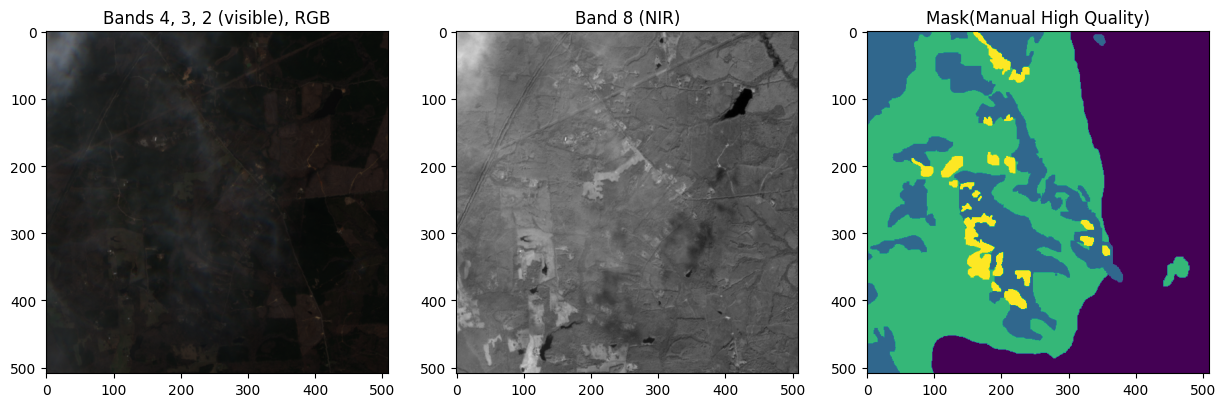

In [10]:
rgb = tiff.imread(Path(cloudSEN12_path, ROI_collection, ROI, '20200306T155019_20200306T160015_T17SQB/S2L2A.tif'))[:, :, 1:4]
rgb = np.flip(rgb, axis=2)
rgb = np.clip(rgb/10000, 0,1)

nir = tiff.imread(Path(cloudSEN12_path, ROI_collection, ROI, '20200306T155019_20200306T160015_T17SQB/S2L2A.tif'))[:, :, 7]

plt.figure(figsize=(15,15))

plt.subplot(131)
plt.title('Bands 4, 3, 2 (visible), RGB')
plt.imshow(rgb)
plt.subplot(132)
plt.title('Band 8 (NIR)')
plt.imshow(nir, cmap='gray')
plt.subplot(133)
plt.title('Mask(Manual High Quality)')
plt.imshow(tiff.imread(Path('/home/floddo/cloud_coverage_TOELT_SUPSI/Data/cloudSEN12/24__ROI_0549__ROI_0570/ROI_0549/20200306T155019_20200306T160015_T17SQB/labels/manual_hq.tif')))

plt.show()

# Sources:
* Dataset: https://www.scidb.cn/en/detail?dataSetId=f72d622ff4ea4fa18070456a98222b1a